# Hyperparameter Tuning
For this image classification task, we've selected the `EfficientNet-B0` model. To achieve the best performance, we need to fine-tune its hyperparameters.

The goal is to find the combination that maximizes the F1 macro score (which is is ideal for imbalanced datasets) on our validation data, ensuring the final model generalizes well.

In [1]:
import sys, os
import json
sys.path.append(os.path.abspath(".."))

import torch
import torch.nn as nn
from torchvision import models

import optuna
import pandas as pd
from IPython.display import Image

from src.data import get_datasets
from src.utils import set_device, EarlyStopper, is_mbconv
from src.train import train_step, val_step

In [2]:
# Configurations
DEVICE = set_device()

datasets = get_datasets(root="../data/augmented_images")
output_dir = "../outputs/tuning"
full_train_ds = datasets["train"]
full_val_ds = datasets["val"]

Device: mps


## Bayesian Hyperparameter Optimization

This section uses the Optuna framework for Bayesian hyperparameter optimization. Unlike a basic grid search, this method selects new hyperparameter combinations based on previous trial results, making the search much more efficient.

The goal of the optimization is to maximize the `F1 macro score` on the validation set. This metric was chosen because the dataset shows a strong class imbalance, and the F1 macro score provides a balanced view of performance across all classes.

Four main hyperparameters are tuned in this process:

- Learning Rate

- Batch Size

- Weight Decay

- Number of Unfrozen Layers

In [3]:
# Set up parameters
TUNING_RANGES = {
    "LR": {"type": "float", "low": 1e-4, "high": 1e-2, "log": True},
    "BATCH_SIZE": {"type": "categorical", "choices": [16, 32, 64]},
    "WEIGHT_DECAY": {"type": "float", "low": 1e-4, "high": 8e-3, "log": True},
    "UNFREEZE_K": {"type": "int", "low": 2, "high": 8},
}

EPOCHS_PER_TRIAL = 7
N_TRIALS = 100

In [4]:
def objective(trial):
    """A single training run, called by Optuna for each trial."""
    
    # 1. Suggest Hyperparameters Dynamically
    params = {}
    for name, p in TUNING_RANGES.items():
        if p['type'] == 'categorical':
            params[name] = trial.suggest_categorical(name, p['choices'])
        elif p['type'] == 'int':
            params[name] = trial.suggest_int(name, p['low'], p['high'])
        elif p['type'] == 'float':
            params[name] = trial.suggest_float(name, p['low'], p['high'], log=p.get('log', False))

    # 2. Setup Model and Training Components
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    in_features = model.classifier[-1].in_features
    model.classifier = nn.Linear(in_features, 8)
    model.to(DEVICE)
    
    # --- Progressive Unfreezing Logic ---
    for p in model.features.parameters(): p.requires_grad = False
    mbconv_blocks = [m for m in model.features.modules() if is_mbconv(m)]
    K = min(params['UNFREEZE_K'], len(mbconv_blocks))
    for m in mbconv_blocks[-K:]:
        for p in m.parameters(): p.requires_grad = True
    for p in model.features[-1].parameters(): p.requires_grad = True
    for p in model.classifier.parameters(): p.requires_grad = True
        
    # --- Dataloaders, Optimizer, etc. ---
    pin = torch.cuda.is_available()
    train_loader = torch.utils.data.DataLoader(
        full_train_ds, 
        batch_size=params['BATCH_SIZE'], 
        shuffle=True, 
        pin_memory=pin
    )
    val_loader = torch.utils.data.DataLoader(
        full_val_ds, 
        batch_size=params['BATCH_SIZE'],
        pin_memory=pin
    )
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=params['LR'], weight_decay=params['WEIGHT_DECAY'])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS_PER_TRIAL)
    
    # 3. Training Loop
    early_stopper = EarlyStopper(mode="max", patience=3, max_overfit_gap=0.10)
    best_f1 = 0.0
    best_metrics_for_trial = {}

    for epoch in range(1, EPOCHS_PER_TRIAL + 1):
        train_metrics = train_step(model, train_loader, criterion, optimizer, DEVICE, disable_tqdm=True)
        val_metrics = val_step(model, val_loader, criterion, DEVICE, disable_tqdm=True)
        scheduler.step()
        
        val_f1 = val_metrics['f1_macro']
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            # You can keep this logic to store the best metrics for the trial
            best_metrics_for_trial = {
                "val_f1_macro": val_metrics['f1_macro'],
                "val_precision": val_metrics['precision_macro'],
                "val_recall": val_metrics['recall_macro'],
                "val_accuracy": val_metrics['accuracy'],
                "val_loss": val_metrics['loss'],
                "train_f1_macro": train_metrics['f1_macro'],
                "train_accuracy": train_metrics['accuracy'],
                "train_loss": train_metrics['loss'],
                "epoch": epoch
            }
            
        # Optuna pruning logic
        trial.report(val_f1, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        # Call the new step method with the correct arguments
        _, should_stop, reason = early_stopper.step(
            val_patience_metric=val_metrics['f1_macro'],
            train_loss=train_metrics['loss'],
            val_loss=val_metrics['loss']
        )
        if should_stop:
            break
    
    trial.set_user_attr("best_metrics", best_metrics_for_trial)
    
    return best_f1

### Start the experiment
To speed up the process, a MedianPruner is used to stop unpromising trials early.

Additionally, through empirical observation, the model tends to overfit rapidly. To mitigate this, early stopping was applied based on the gap between the training and validation F1 macro scores, ensuring that training halts once overfitting becomes evident.

In [5]:
# Create a study object and specify the direction is to maximize the F1 score
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())

try:
    # Start the optimization process
    study.optimize(objective, n_trials=N_TRIALS, timeout=3600)
except KeyboardInterrupt:
    print("Study interrupted manually. Results up to this point will be shown.")
    
print("\n" + "="*50)
print("HYPERPARAMETER TUNING COMPLETE")
print(f"Number of finished trials: {len(study.trials)}")

[I 2025-10-15 18:34:16,508] A new study created in memory with name: no-name-e901f1bb-2406-4534-ba94-da87d1b7d94a
[I 2025-10-15 18:34:52,297] Trial 0 finished with value: 0.6986667422080834 and parameters: {'LR': 0.004571964798429264, 'BATCH_SIZE': 16, 'WEIGHT_DECAY': 0.006135973919805578, 'UNFREEZE_K': 5}. Best is trial 0 with value: 0.6986667422080834.
[I 2025-10-15 18:35:07,623] Trial 1 finished with value: 0.7516466491747607 and parameters: {'LR': 0.0015643800762325322, 'BATCH_SIZE': 64, 'WEIGHT_DECAY': 0.000919237003991929, 'UNFREEZE_K': 4}. Best is trial 1 with value: 0.7516466491747607.
[I 2025-10-15 18:35:15,188] Trial 2 finished with value: 0.6663751578123329 and parameters: {'LR': 0.0035907788678335066, 'BATCH_SIZE': 64, 'WEIGHT_DECAY': 0.0009930737083984006, 'UNFREEZE_K': 5}. Best is trial 1 with value: 0.7516466491747607.
[I 2025-10-15 18:36:05,347] Trial 3 finished with value: 0.7577291660331071 and parameters: {'LR': 0.005428398375805644, 'BATCH_SIZE': 16, 'WEIGHT_DECAY':


HYPERPARAMETER TUNING COMPLETE
Number of finished trials: 100


In [6]:
print("--- Best Trial ---")
best_trial = study.best_trial

print(f"Value (val_f1_macro): {best_trial.value:.4f}")
print("Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")
    
print("\n--- Full Metrics for Best Trial ---")
best_metrics = best_trial.user_attrs.get("best_metrics", {})
print(pd.Series(best_metrics).to_string())

--- Best Trial ---
Value (val_f1_macro): 0.8057
Params: 
    LR: 0.0006358417306510211
    BATCH_SIZE: 64
    WEIGHT_DECAY: 0.0053798915552686665
    UNFREEZE_K: 6

--- Full Metrics for Best Trial ---
val_f1_macro      0.805718
val_precision     0.807395
val_recall        0.806661
val_accuracy      0.817757
val_loss          0.583689
train_f1_macro    0.874641
train_accuracy    0.874889
train_loss        0.413537
epoch             2.000000


In [7]:
file_path = os.path.join(output_dir, "best_hyperparameters.json")

with open(file_path, 'w') as f:
    json.dump(best_trial.params, f, indent=4)

print(f"Best hyperparameters saved to {file_path}")

Best hyperparameters saved to ../outputs/tuning/best_hyperparameters.json


Those hyperparameters will be used for the training of the model for our classification task.

In [8]:
# --- Create a DataFrame with full results from all trials ---
all_trials = []
for trial in study.trials:
    if trial.state == optuna.trial.TrialState.COMPLETE:
        trial_metrics = trial.user_attrs.get("best_metrics", {})
        # Combine hyperparameters and the resulting metrics
        row = {**trial.params, **trial_metrics}
        all_trials.append(row)

results_df = pd.DataFrame(all_trials)

# Add the overfitting gap and sort
if 'train_accuracy' in results_df.columns and 'val_accuracy' in results_df.columns:
    results_df['overfit_gap'] = results_df['train_f1_macro'] - results_df['val_f1_macro']

sorted_df = results_df.sort_values(by="val_f1_macro", ascending=False).reset_index(drop=True)

print("\n--- Full Results Leaderboard (Sorted by val_f1_macro) ---")
pd.set_option('display.width', 120)
display(sorted_df.head(5))


--- Full Results Leaderboard (Sorted by val_f1_macro) ---


,LR,BATCH_SIZE,WEIGHT_DECAY,UNFREEZE_K,val_f1_macro,val_precision,val_recall,val_accuracy,val_loss,train_f1_macro,train_accuracy,train_loss,epoch,overfit_gap
0,0.000636,64,0.005380,6,0.805718,0.807395,0.806661,0.817757,0.583689,0.874641,0.874889,0.413537,2,0.068923
1,0.000327,32,0.004626,8,0.800939,0.806018,0.799374,0.803738,0.595797,0.924041,0.923865,0.269413,3,0.123102
2,0.000845,32,0.005395,8,0.796387,0.818882,0.800109,0.803738,0.744071,0.621518,0.621549,1.106013,1,-0.174868
3,0.000789,64,0.002296,7,0.794856,0.814489,0.793785,0.813084,0.708324,0.891668,0.891808,0.360237,2,0.096812
4,0.000729,64,0.005320,8,0.789944,0.790618,0.808101,0.808411,0.598702,0.622649,0.623776,1.177171,1,-0.167295


In [9]:
file_path = os.path.join(output_dir, "hyperparam-tuning-results.csv")

sorted_df.to_csv(file_path)

print(f"All results saved to {file_path}")

All results saved to ../outputs/tuning/hyperparam-tuning-results.csv


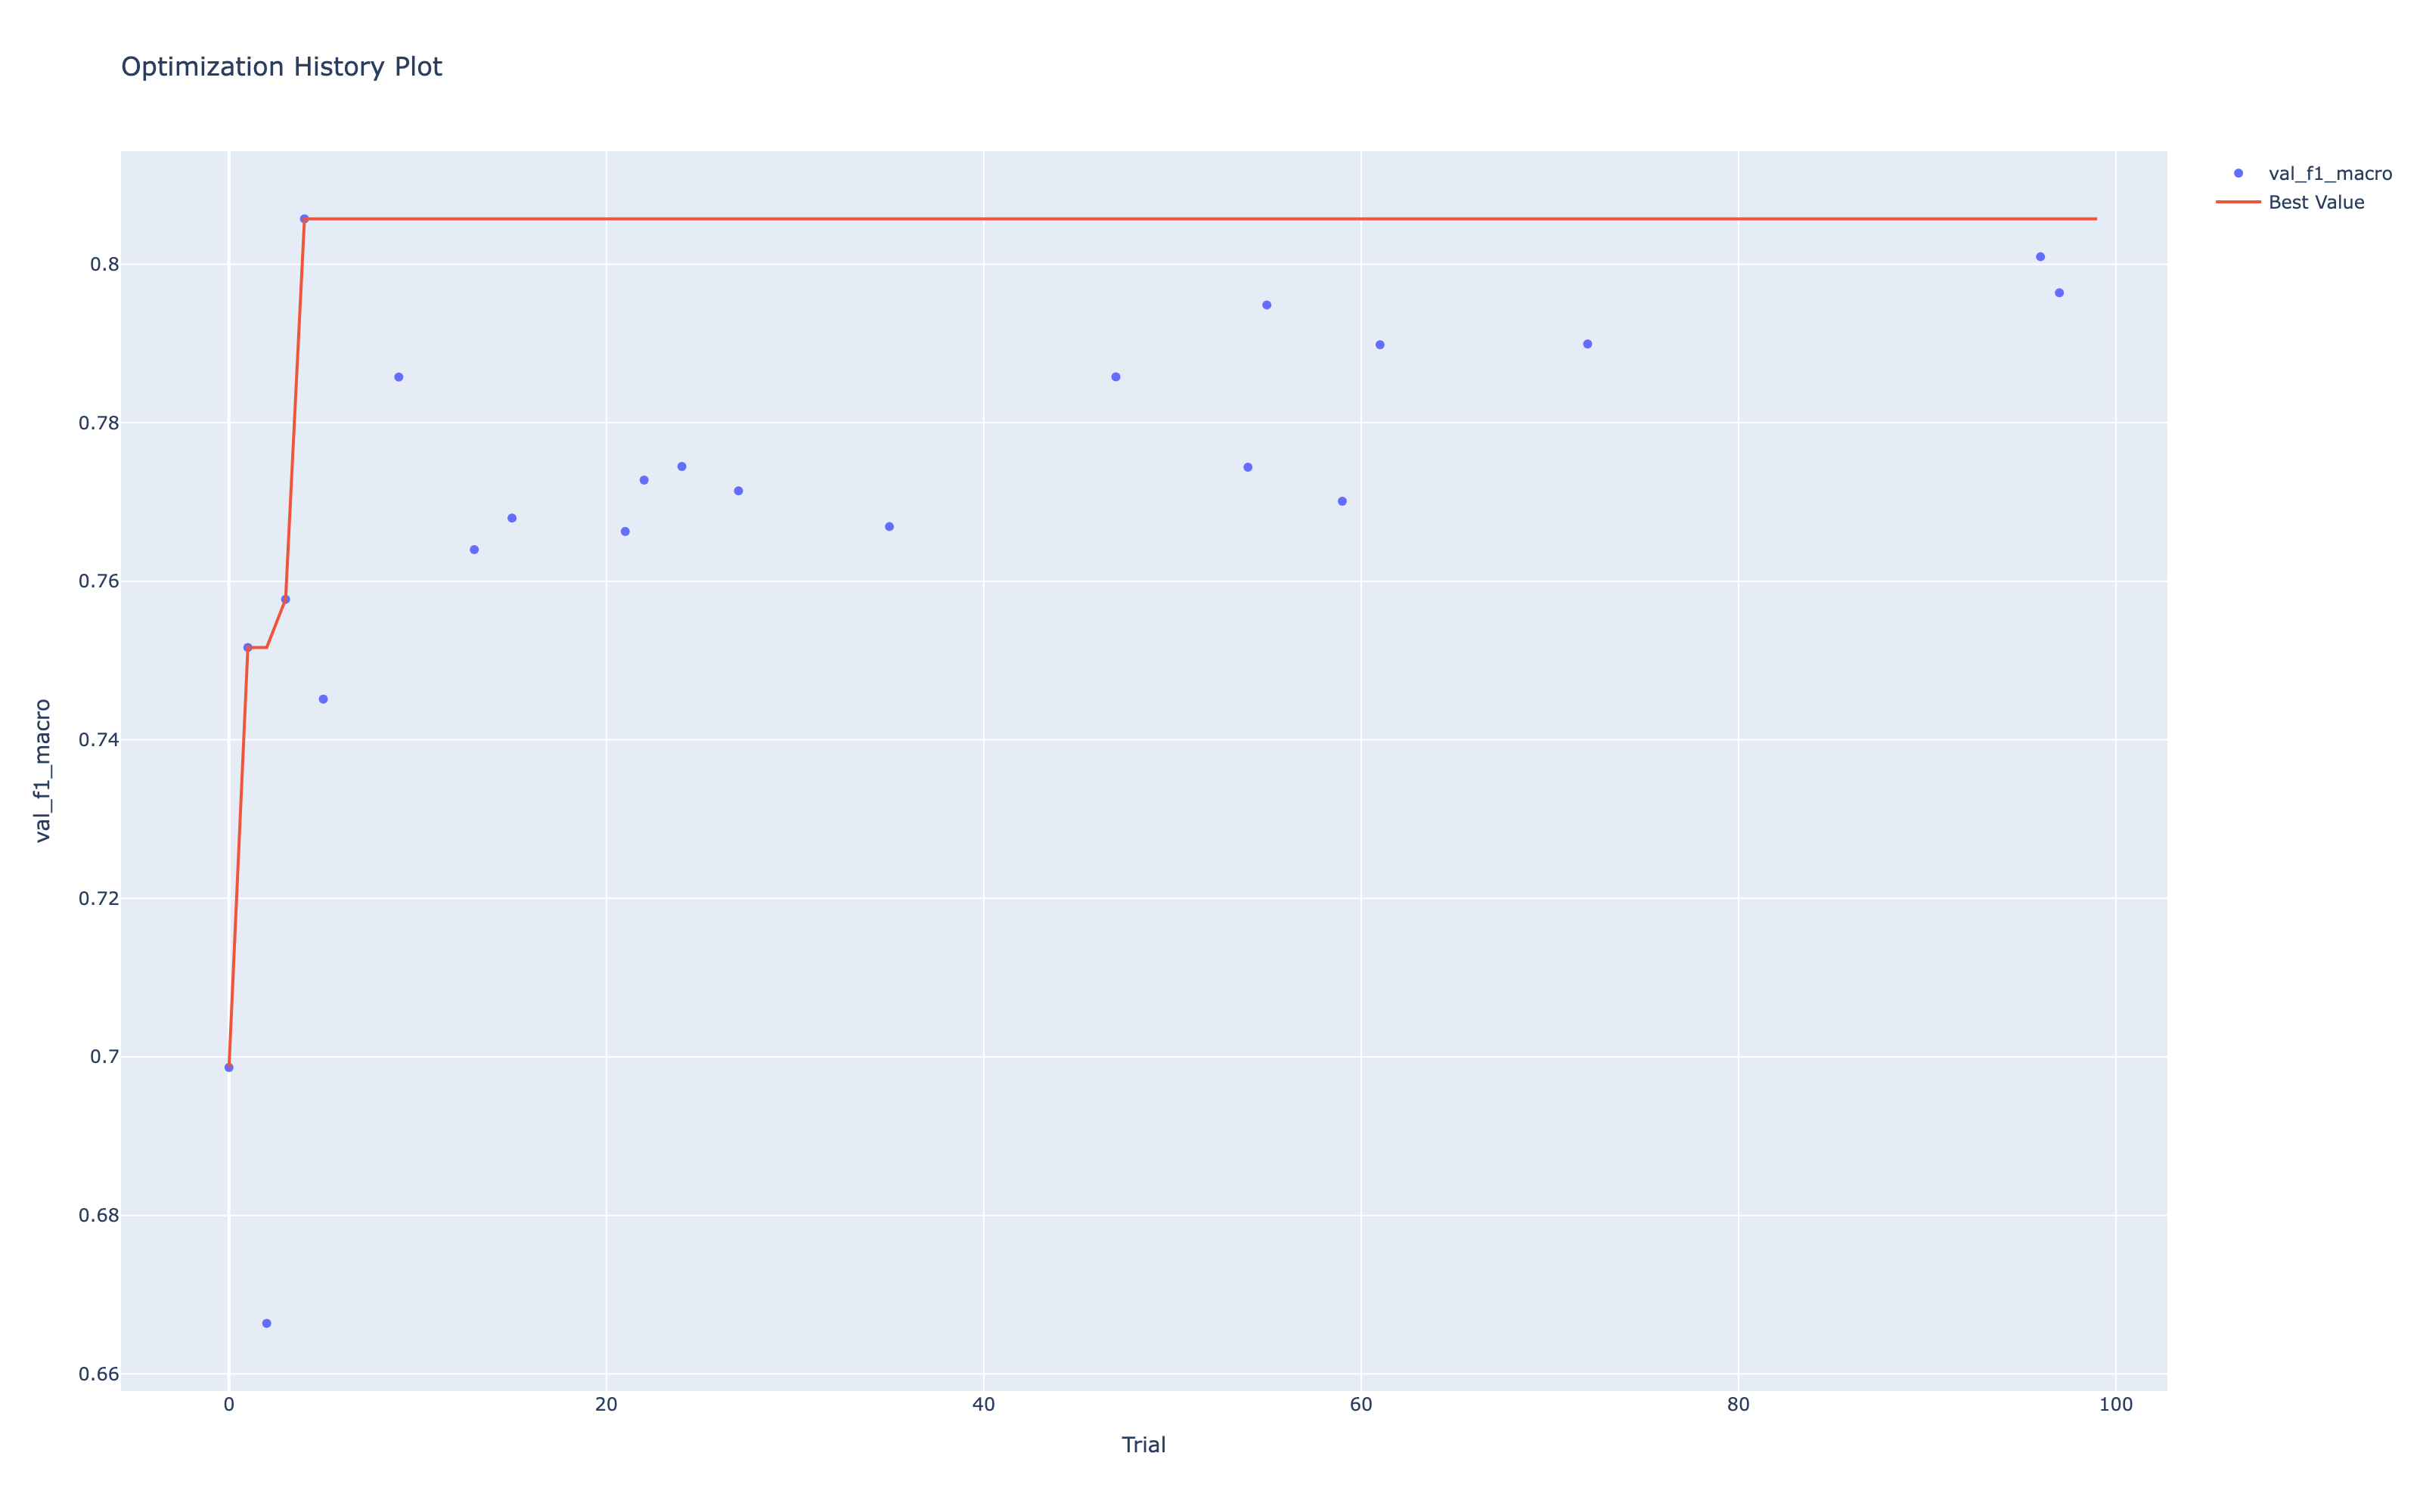

In [10]:
# Shows how the F1-score improved over trials
fig = optuna.visualization.plot_optimization_history(study, target_name="val_f1_macro")
file_path = os.path.join(output_dir, "optimization_history.png")
fig.write_image(file_path, width=1600, height=1000, scale=2)

# Display it in the notebook
Image(filename=file_path)

As shown in the optimization history, performance improved rapidly within the first few trials and stabilized thereafter.

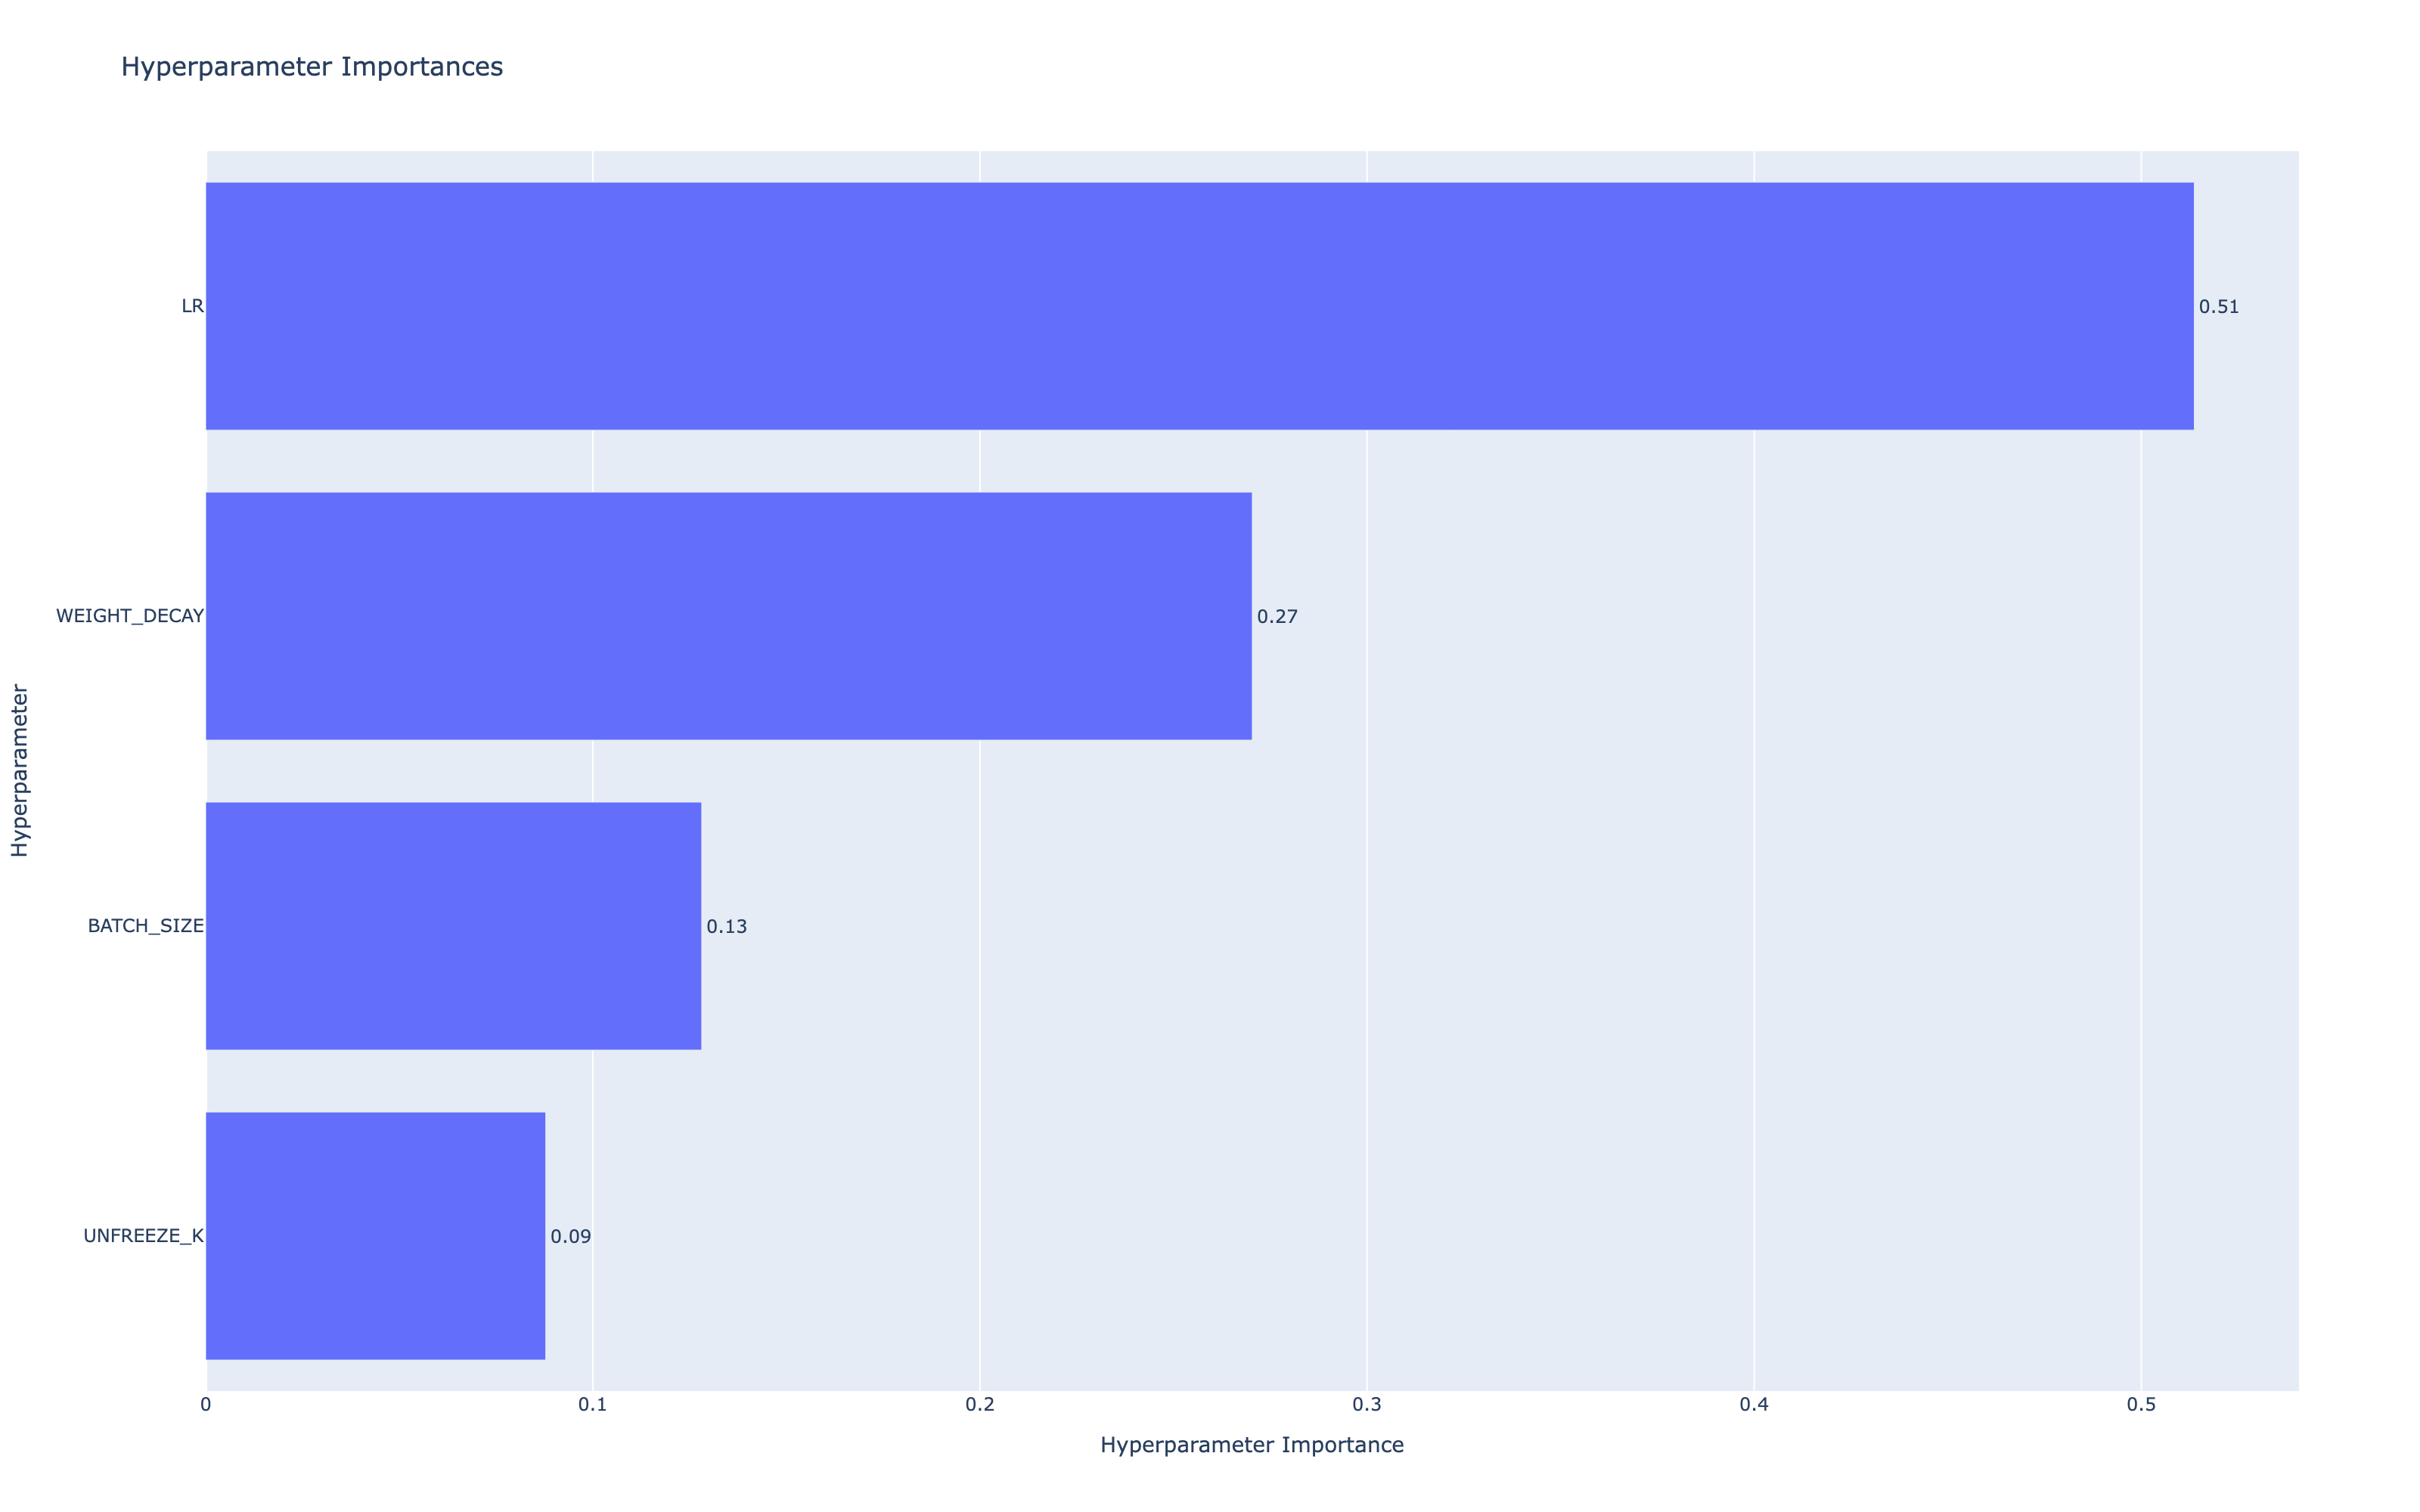

In [11]:
# Shows which hyperparameters were most important
fig = optuna.visualization.plot_param_importances(study, target_name="val_f1_macro")
file_path = os.path.join(output_dir, "param-importances.png")
fig.write_image(file_path, width=1600, height=1000, scale=2)

# Display it in the notebook
Image(filename=file_path)

The hyperparameter importance analysis indicates that learning rate and batch size had the largest impact on model performance.